# Import

In [1]:
import sys
import os
from datetime import datetime

root_dir = '../../../'
if root_dir not in sys.path:
    sys.path.append(root_dir)

import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import pandas as pd

pd.set_option('display.max_columns', 100)

from modules import losses, models, samplers, searches, regularizers, evaluators, trainers, datasets, distributions

# Output settings

In [2]:
out_to_file = True
out_dir = '../../out/sampling/ml_100k/'

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Dataset

In [3]:
dataset = datasets.ML100k()
n_user = dataset.n_user
n_item = dataset.n_item
n_feedback = dataset.n_pos_pairs
train_set, test_set = dataset.get_train_and_test_set(neg_pair_weight=10)

In [4]:
print(f'n_user = {n_user}')
print(f'n_item = {n_item}')
print(f'n_feedback = {n_feedback}')

n_user = 940
n_item = 1447
n_feedback = 55369


# Device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_set = torch.LongTensor(train_set).to(device)
test_set = torch.FloatTensor(test_set).to(device)

In [6]:
print(device)

cuda:0


# Evaluator

In [7]:
# The size of recommendation set (K)
ks = [10]

score_function_dict = {
    "Recall"        : evaluators.recall,
    "Unpopularity"  : evaluators.unpopularity,
    "Serendipity"   : evaluators.serendipity,
    "Long-tail rate": evaluators.longtail_rate,
}
userwise = evaluators.UserwiseEvaluator(test_set, score_function_dict, ks)

# Sampler

In [8]:
sampler = samplers.BaseSampler(train_set, n_user, n_item, device=device, strict_negative=False)

# Model

In [9]:
# Hyperparameters
lr = 1e-3
n_dim = 10
n_batch = 256
n_epoch = 50
no_progressbar = True

model = models.CollaborativeMetricLearning(n_user, n_item, n_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = losses.SumTripletLoss(margin=1).to(device)
trainer = trainers.BaseTrainer(model, optimizer, criterion, sampler, no_progressbar)

# Training

In [10]:
trainer.fit(n_batch, n_epoch)

# Result

## CML (Base)

In [11]:
knn = searches.NearestNeighborhood(model)

In [12]:
trainer.valid(knn, userwise)
re_base = trainer.valid_scores.copy()

In [13]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("base_%Y_%m_%d_%H%M.csv")
    re_base.to_csv(out_dir + file_name, index=False)

display(re_base)

,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,0.570142,27.815671,6.952736,0.175426


# MPCMP

In [14]:
# Hyperparameters
n_sample_li = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
bias_1 = 0.5
bias_2 = 0.8
gamma = distributions.Gamma()

In [15]:
rows_1 = []
rows_2 = []
for n_sample in n_sample_li:
    print(f'Prosessing... [n_sample = {n_sample}]')
    
    # α = 0.5
    mp = searches.MutualProximity(model, gamma, n_sample, bias_1)
    trainer.valid(mp, userwise)
    row = trainer.valid_scores.copy()
    row.insert(0, 'n_sample', n_sample)
    rows_1.append(row)
    
    # α = 0.8
    mp = searches.MutualProximity(model, gamma, n_sample, bias_2)
    trainer.valid(mp, userwise)
    row = trainer.valid_scores.copy()
    row.insert(0, 'n_sample', n_sample)
    rows_2.append(row)

re_mpcml_1 = pd.concat(rows_1)
re_mpcml_2 = pd.concat(rows_2)

Prosessing... [n_sample = 10]
Prosessing... [n_sample = 20]
Prosessing... [n_sample = 30]
Prosessing... [n_sample = 40]
Prosessing... [n_sample = 50]
Prosessing... [n_sample = 60]
Prosessing... [n_sample = 70]
Prosessing... [n_sample = 80]
Prosessing... [n_sample = 90]
Prosessing... [n_sample = 100]


In [16]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("mpcml_bias1_%Y_%m_%d_%H%M.csv")
    re_mpcml_1.to_csv(out_dir + file_name, index=False)

display(re_mpcml_1)

,n_sample,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,10,0.469868,68.979567,8.916179,0.414681
0,20,0.480012,65.173070,9.034169,0.406809
0,30,0.485174,66.167537,8.872491,0.404255
0,40,0.485741,65.136021,9.106276,0.405213
0,50,0.489787,64.469656,9.163572,0.399681
0,60,0.488947,63.209977,9.165809,0.398085
0,70,0.489378,64.321575,9.097948,0.403723
0,80,0.489816,63.422300,9.106388,0.401064
0,90,0.491187,63.572675,9.118474,0.397553
0,100,0.488375,63.968909,8.996473,0.400319


In [17]:
if out_to_file:
    now = datetime.now()
    file_name = now.strftime("mpcml_bias2_%Y_%m_%d_%H%M.csv")
    re_mpcml_2.to_csv(out_dir + file_name, index=False)

display(re_mpcml_2)

,n_sample,Recall@10,Unpopularity@10,Serendipity@10,Long-tail rate@10
0,10,0.517541,47.637704,8.374599,0.321489
0,20,0.522274,44.660827,8.334203,0.315745
0,30,0.528040,43.663243,8.353682,0.306702
0,40,0.527666,42.483120,8.332580,0.301170
0,50,0.531237,42.200717,8.268990,0.300638
0,60,0.530852,42.519209,8.259911,0.296915
0,70,0.532032,42.418722,8.313102,0.296915
0,80,0.527995,41.952770,8.229262,0.298298
0,90,0.531059,41.892893,8.206223,0.295638
0,100,0.530928,42.408742,8.400142,0.297447


## Show

In [30]:
# df -> list

k = 10
n_n_sample = len(n_sample_li)

# CML(Base)
recall_base           = re_base[f'Recall@{k}'].tolist() * n_n_sample
unpopularity_base     = re_base[f'Unpopularity@{k}'].tolist() * n_n_sample
serendipity_base      = re_base[f'Serendipity@{k}'].tolist() * n_n_sample
longtale_base         = re_base[f'Long-tail rate@{k}'].tolist() * n_n_sample

# MPCML (α = 0.5)
recall_mpcml_1        = re_mpcml_1[f'Recall@{k}'].tolist()
unpopularity_mpcml_1  = re_mpcml_1[f'Unpopularity@{k}'].tolist()
serendipity_mpcml_1   = re_mpcml_1[f'Serendipity@{k}'].tolist()
longtale_mpcml_1      = re_mpcml_1[f'Long-tail rate@{k}'].tolist()

# MPCML (α = 0.8)
recall_mpcml_2        = re_mpcml_2[f'Recall@{k}'].tolist()
unpopularity_mpcml_2  = re_mpcml_2[f'Unpopularity@{k}'].tolist()
serendipity_mpcml_2   = re_mpcml_2[f'Serendipity@{k}'].tolist()
longtale_mpcml_2      = re_mpcml_2[f'Long-tail rate@{k}'].tolist()

### Recall

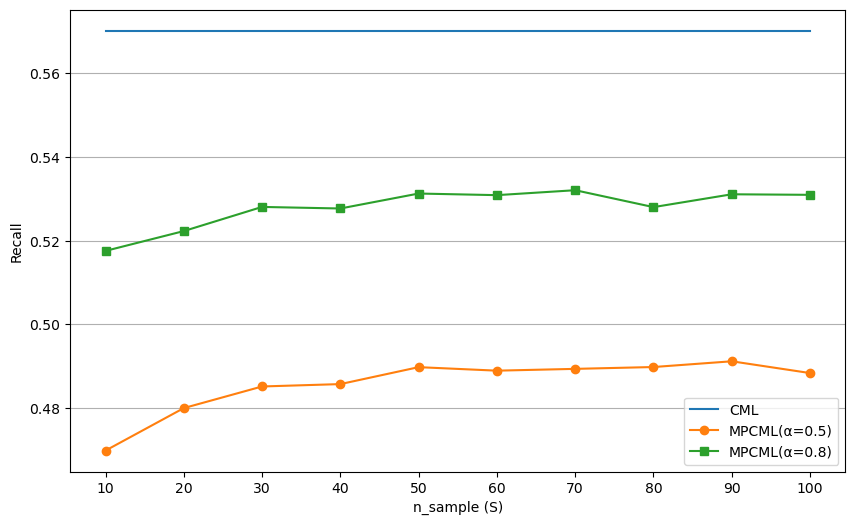

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(n_sample_li, recall_base, label='CML')
plt.plot(n_sample_li, recall_mpcml_1, label='MPCML(α=0.5)', marker='o')
plt.plot(n_sample_li, recall_mpcml_2, label='MPCML(α=0.8)', marker='s')

plt.xticks(n_sample_li)
plt.xlabel('n_sample (S)')
plt.ylabel('Recall')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("recall_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Unpopularity

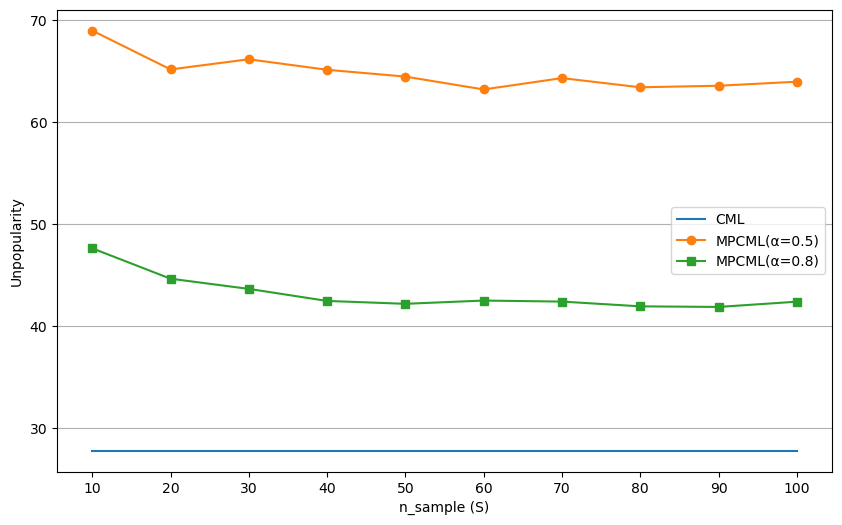

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(n_sample_li, unpopularity_base, label='CML')
plt.plot(n_sample_li, unpopularity_mpcml_1, label='MPCML(α=0.5)', marker='o')
plt.plot(n_sample_li, unpopularity_mpcml_2, label='MPCML(α=0.8)', marker='s')

plt.xticks(n_sample_li)
plt.xlabel('n_sample (S)')
plt.ylabel('Unpopularity')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("unpopularity_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Serendipity

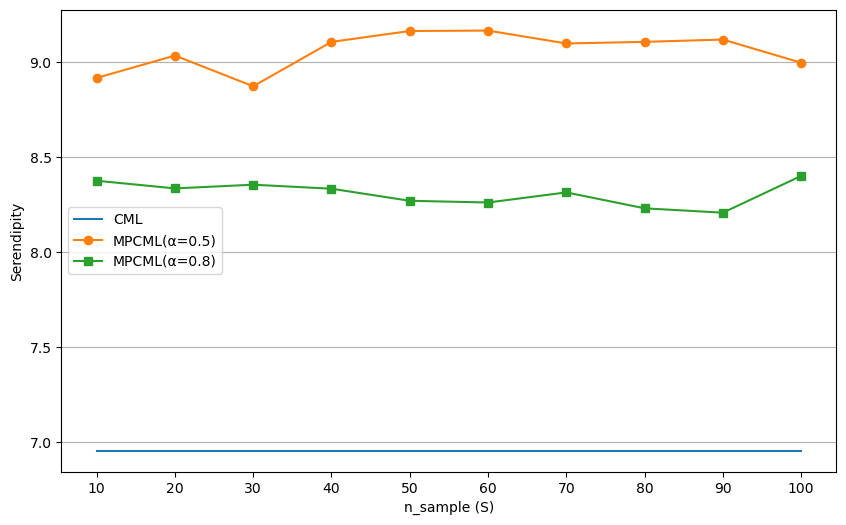

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(n_sample_li, serendipity_base, label='CML')
plt.plot(n_sample_li, serendipity_mpcml_1, label='MPCML(α=0.5)', marker='o')
plt.plot(n_sample_li, serendipity_mpcml_2, label='MPCML(α=0.8)', marker='s')

plt.xticks(n_sample_li)
plt.xlabel('n_sample (S)')
plt.ylabel('Serendipity')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("serendipity_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()

### Long-tail rate

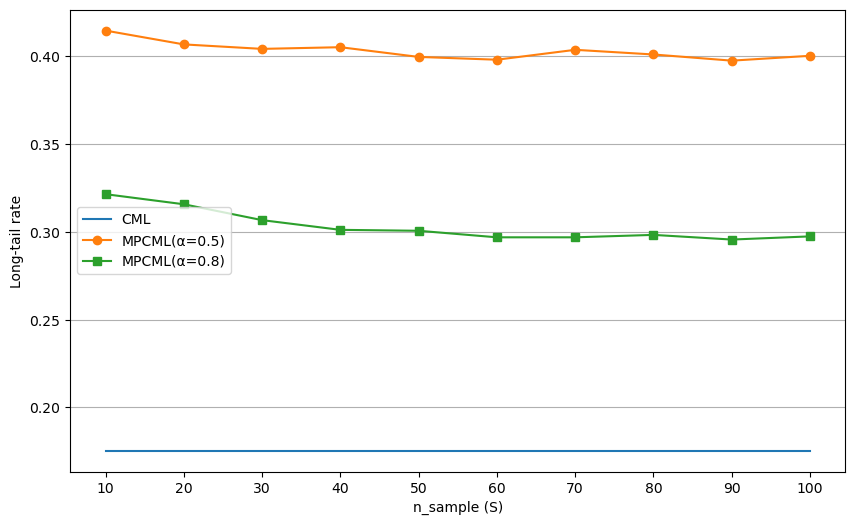

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(n_sample_li, longtale_base, label='CML')
plt.plot(n_sample_li, longtale_mpcml_1, label='MPCML(α=0.5)', marker='o')
plt.plot(n_sample_li, longtale_mpcml_2, label='MPCML(α=0.8)', marker='s')

plt.xticks(n_sample_li)
plt.xlabel('n_sample (S)')
plt.ylabel('Long-tail rate')
plt.legend()
plt.grid(axis='y')

if out_to_file:
    now = datetime.now()
    file_name = now.strftime("longtail_%Y_%m_%d_%H%M.png")
    plt.savefig(out_dir + file_name, bbox_inches='tight')

plt.show()